In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf
from scalebars import *

import balance_configs as configs
# from ei_balance import Model
# from Rig import Rig
import experiments as exps
import analysis as ana

In [2]:
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
# data_path = "/mnt/Data/NEURONoutput/sac_net/committee_runs/"
base_path = "/mnt/Data/NEURONoutput/sac_net/"

## TODO:
- update the synapses to enable poisson quantal input, as in the sac-sac model
- fill out notebook with figures and interactive displays

Average GABA synapse count: 143.48


<IPython.core.display.Javascript object>


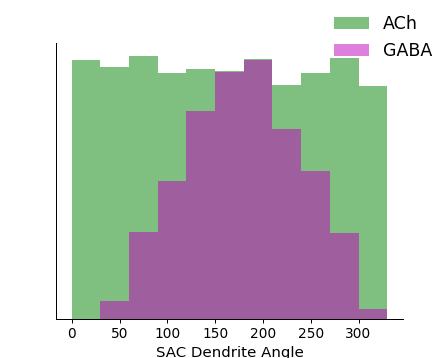

In [4]:
model_config = configs.sac_mode_config(ttx=False)
angle_dist_fig, angle_dist_ax = ana.sac_angle_distribution(
    model_config, n_nets=25, bins=[12], figsize=(5, 4))

In [5]:
model_path = os.path.join(base_path, "model_runs")
save_name = "test"
# load_name = None
load_name = "test"

model_config = configs.sac_mode_config(ttx=False)

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_run(
        save_path,
        model_config,
        n_nets=3,
        n_trials=3,
        rho_steps=[0.0, 1.0],
        pool_sz=8,
    )

t0 = time.time()
with h5.File(os.path.join(model_path, load_name) + ".h5", "r") as pckg:
    d = unpack_hdf(pckg)
print("data unpacked in %.1fs" % (time.time() - t0))
    
# deserialize parameter dicts
for i in d.keys():
    for rho in d[i].keys():
        d[i][rho]["params"] = json.loads(d[i][rho]["params"])
        
# rearrange hierarchy (rho condition above repeats)
rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())

data unpacked in 31.8s


In [6]:
metrics = ana.get_sac_metrics(d)

dir_labels = d[rhos[0]][idxs[0]]["params"]["dir_labels"]
tuning = ana.analyze_tree(d, dir_labels, pref=0, thresh=-57)
sac_thetas = ana.get_sac_thetas(d)
sac_deltas = ana.get_sac_deltas(sac_thetas)

<IPython.core.display.Javascript object>


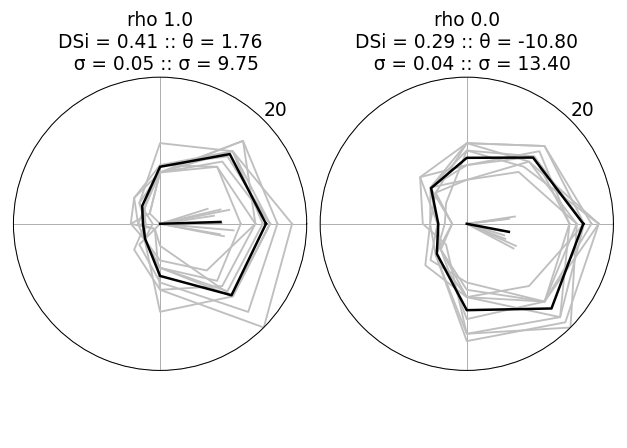

In [7]:
max_spikes = np.max([r["spikes"] for r in metrics.values()])
polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=polar_fig,
        sub_loc=int("1%i%i" % (n_cols, loc + 1)),
    )
    for loc, (r, m) in enumerate(metrics.items())
]
polar_fig.tight_layout()

<IPython.core.display.Javascript object>


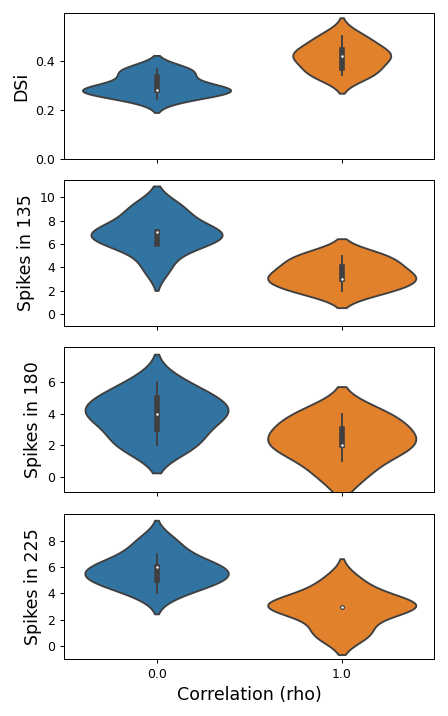

In [8]:
violins = sac_rho_violins(metrics, dir_labels, figsize=(5, 8))

<IPython.core.display.Javascript object>


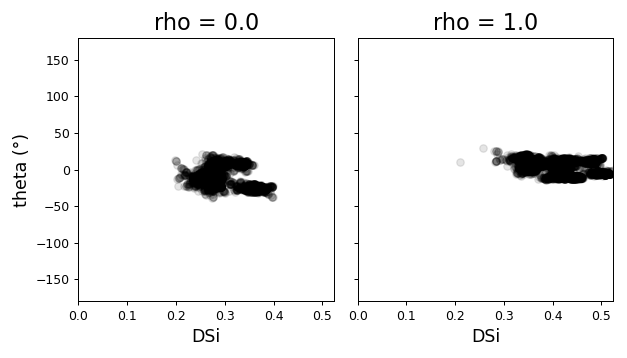

In [9]:
scatter_fig = ds_scatter(tuning, figsize=(7, 4))
scatter_fig.tight_layout()

<IPython.core.display.Javascript object>


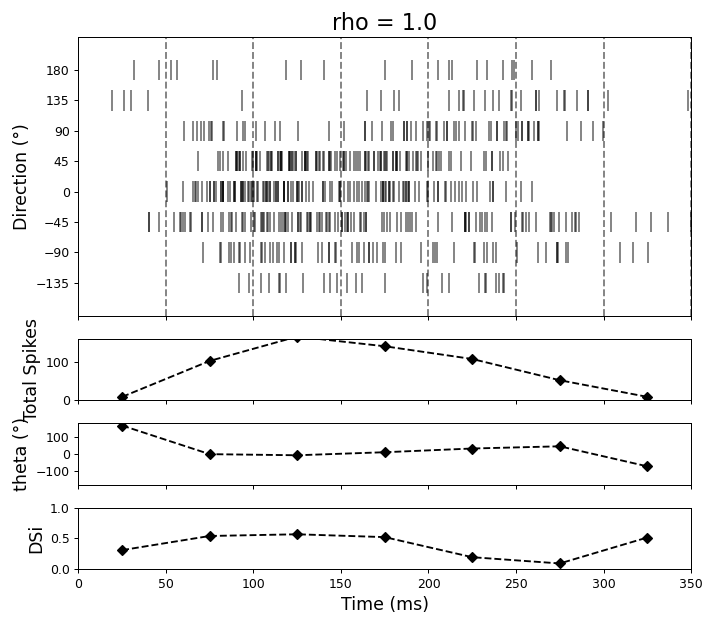

In [10]:
dir_field_offsets = [11.0, 18.8, 37.8, 13.8, 0.8, 19.3, 16.0, 0.0]  # ms
rasters_fig = spike_rasters(
    d,
    dir_labels,
    rho=1.,
    bin_ms=50,
    offsets=dir_field_offsets,
    colour="black",
    spike_vmax=160,
    figsize=(8, 7),
)

<IPython.core.display.Javascript object>


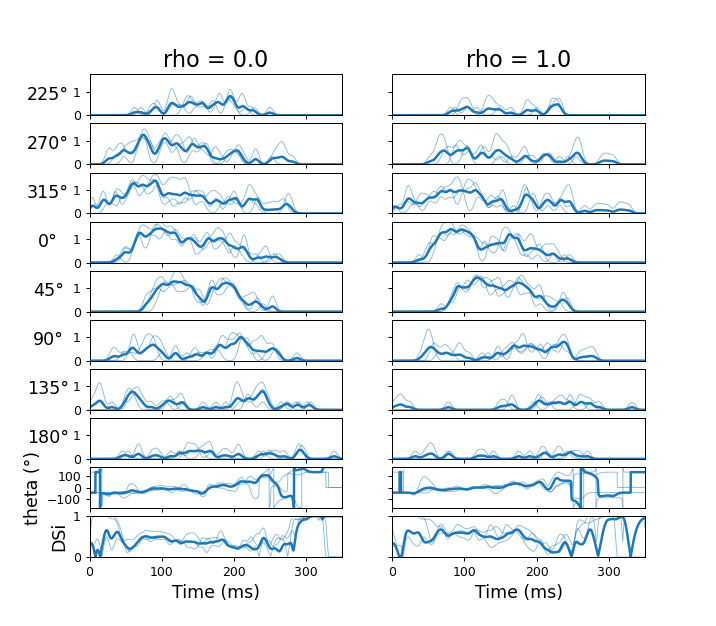

In [11]:
evol = time_evolution(d, dir_labels, kernel_var=45, figsize=(8, 7))

In [12]:
if d[0.0][0]["params"]["soma_Na"] == 0.0:  # TTX condition
    rec_locs = d[0.0][0]["dendrites"]["locs"]
    syn_locs = d[0.0][0]["syn_locs"]
    syn_rec_lookups = get_syn_rec_lookups(rec_locs, syn_locs)
    post_syn_avg_tuning = get_postsyn_avg_tuning(tuning, syn_rec_lookups)
    theta_diffs = plot_theta_diff_tuning_scatters(post_syn_avg_tuning, sac_deltas, rhos=[0.])
    theta_diff_bins = plot_theta_diff_vs_abs_theta(post_syn_avg_tuning, sac_deltas, rhos=[0.])

<IPython.core.display.Javascript object>


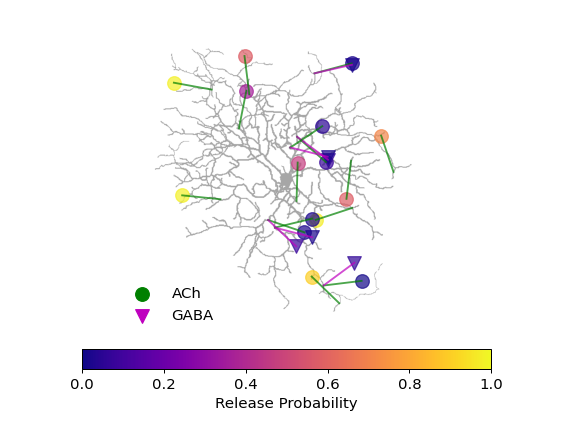

In [13]:
rho = 0.0
net = 0

over_fig, over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    over_fig,
    over_ax,
    io.imread("assets/dsgc.png")[:, :, 0],
    d[rho][net]["syn_locs"],
    d[rho][net]["sac_net"]["wiring"]["bp_locs"],
    d[rho][net]["sac_net"]["wiring"]["probs"],
    dir_labels,
    stim_angle=0,
    n_syn=15,
)
over_fig.tight_layout()

<IPython.core.display.Javascript object>


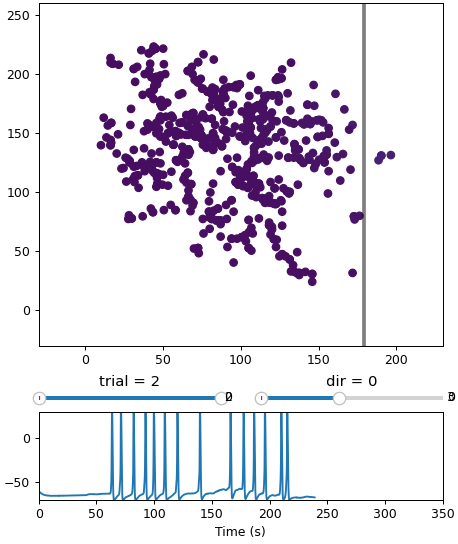

In [60]:
from matplotlib.widgets import Slider

class MotionResponse:
    def __init__(
        self,
        net_data,
        delta=15,
        rec_dt=0.1,
        figsize=(5, 6)
    ):
#         self.fig, self.ax = plt.subplots(
#             4, 1, gridspec_kw={"height_ratios": [0.6, 0.1, 0.1, 0.2]}, figsize=figsize,
#         )
#         self.tree_ax, self.trial_slide_ax, self.dir_slide_ax, self.soma_ax = self.ax
        self.d = net_data
        self.soma = net_data["soma"]["Vm"]
        self.tree = net_data["dendrites"]["Vm"]
        self.dirs = net_data["params"]["dir_labels"]
        
        self.n_trials = self.soma.shape[0]
        self.soma_pts = self.soma.shape[-1]
        self.tree_pts = self.tree.shape[-1]
        
        self.build_fig(figsize)
        
        self.delta = delta
        self.rate_diff = self.soma_pts // self.tree_pts
        self.tree_t = 0
        
        locs = net_data["dendrites"]["locs"]
        vmin, vmax = np.min(self.tree), np.max(self.tree)
        self.scat = self.tree_ax.scatter(
            locs[:, 0], locs[:, 1], c=self.tree[0, 0, :, 0], vmin=vmin, vmax=vmax)
    
        self.init_bar_sweeps(net_data["params"])
        self.stim = self.tree_ax.plot(
            self.sweeps[0]["x"], self.sweeps[0]["y"], c="black", linewidth=3, alpha=0.5)
        self.tree_ax.set_xlim(-30, 230)
        self.tree_ax.set_ylim(-30, 260)
    
        self.time = np.linspace(0, self.soma_pts * rec_dt, self.soma_pts)
        self.line = self.soma_ax.plot(self.time[0], self.soma[0, 0, 0])
        self.soma_ax.set_xlim(self.time.min(), self.time.max())
        self.soma_ax.set_ylim(-70, 30)
        
        self.build_trial_slide_ax()
        self.build_dir_slide_ax()
        self.connect_events()
        
        self.update()
        
    def build_fig(self, figsize):
        self.fig = plt.figure(constrained_layout=True, figsize=figsize)
        gs = self.fig.add_gridspec(nrows=3, ncols=2, height_ratios=[0.78, 0.02, 0.2])
        self.tree_ax = self.fig.add_subplot(gs[0, :])
        self.trial_slide_ax = self.fig.add_subplot(gs[1, 0])
        self.build_trial_slide_ax()
        self.dir_slide_ax = self.fig.add_subplot(gs[1, 1])
        self.build_dir_slide_ax()
        self.soma_ax = self.fig.add_subplot(gs[2, :])
        self.soma_ax.set_xlabel("Time (s)")
 
    def init_bar_sweeps(self, ps):
        bar_start = np.array([ps["light_bar"]["x_start"], ps["origin"][1]])
        self.sweeps = {}
        for i in range(len(ps["dir_labels"])):
            bar_x, bar_y = ana.generate_bar_sweep({
                "theta": ps["dir_labels"][i],
                "net_origin": ps["origin"],
                "start": bar_start,
                "speed": ps["light_bar"]["speed"],
                "dt": ps["dt"],
                "n_pts": self.soma_pts,
            })
            self.sweeps[i] = {"x": bar_x, "y": bar_y}
        
    def build_trial_slide_ax(self):
        self.trial_idx = 0
        self.trial_slider = Slider(
            self.trial_slide_ax,
            "",
            valmin=0,
            valmax=(self.n_trials - 1),
            valinit=0,
            valstep=1,
            valfmt="%.0f",
        )
        self.trial_slider.valtext.set_visible(False
        self.trial_slide_ax.set_title("trial = %i" % 0)
 
    def on_trial_slide(self, v):
        self.trial_idx = int(v)
        self.update()
        self.trial_slide_ax.set_title("trial = %i" % self.trial_idx)
        
    def build_dir_slide_ax(self):
        self.dir_idx = 0
        self.dir_slider = Slider(
            self.dir_slide_ax,
            "",
            valmin=0,
            valmax=(len(self.dirs) - 1),
            valinit=0,
            valstep=1,
            valfmt="%.0f",
        )
        self.trial_slider.valtext.set_visible(False
        self.dir_slide_ax.set_title("dir = %i" % self.dirs[0])
 
    def on_dir_slide(self, v):
        self.dir_idx = int(v)
        self.dir_slide_ax.set_title("dir = %i" % self.dirs[self.dir_idx])
        self.update()
     
    def on_scroll(self, event):
        if event.button == "up":
            self.tree_t = (self.tree_t + self.delta) % self.tree_pts
        else:
            self.tree_t = (self.tree_t - self.delta) % self.tree_pts
        self.update()

    def update(self):
        self.scat.set_array(self.tree[self.trial_idx, self.dir_idx, :, self.tree_t])
        self.line[0].set_xdata(self.time[: self.tree_t * self.rate_diff])
        self.line[0].set_ydata(
            self.soma[self.trial_idx, self.dir_idx, : self.tree_t * self.rate_diff])
        self.stim[0].set_xdata(self.sweeps[self.dir_idx]["x"][self.tree_t * self.rate_diff])
        self.stim[0].set_ydata(self.sweeps[self.dir_idx]["y"][self.tree_t * self.rate_diff])
        self.scat.axes.figure.canvas.draw()

    def connect_events(self):
        self.fig.canvas.mpl_connect("scroll_event", self.on_scroll)
        self.trial_slider.on_changed(self.on_trial_slide)
        self.dir_slider.on_changed(self.on_dir_slide)
        
# TODO: a better class that allows switching through nets and directions (sliders). 
# Requires more of the automated prep that went into "make_sac_rec_gifs" to make this 
# stim dict, but should be cleaned up to just generate the bar positions without the dict. 
# Should allow setting the desired recording to display in the tree (vm, ca, etc).

# ps = d[0.0][0]["params"]
# bar_start = np.array([ps["light_bar"]["x_start"], ps["origin"][1]])
# stim = {
#     "theta": dir_labels[0],
#     "net_origin": ps["origin"],
#     "start": bar_start,
#     "speed": ps["light_bar"]["speed"],
#     "dt": ps["dt"],
#     "n_pts": d[0.0][0]["soma"]["Vm"][0, 0].shape[0],
# }

# mr = MotionResponse(
#     stim, 
#     d[0.0][0]["soma"]["Vm"][0, 0], 
#     d[0.0][0]["dendrites"]["Vm"][0, 0],
#     d[0.0][0]["dendrites"]["locs"]
# )
mr = MotionResponse(d[0.0][0])

In [30]:
# for k in d[0.0][0]["params"].keys():
#     print(k)

In [23]:
d[0.0][0].keys()

dict_keys(['syn_locs', 'soma', 'sac_net', 'params', 'metrics', 'dendrites'])

In [34]:
d[0.0][0]["soma"]["Vm"][0, 0].shape

(3501,)